## Customer Segmentation via K-Means Clustering

## Setting Up Spark Environment

In [26]:
import os

# Set Java and Spark paths
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@17"
os.environ["SPARK_HOME"] = "/opt/homebrew/Cellar/apache-spark/4.0.0/libexec"

from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("PreprocessingNotebook") \
    .getOrCreate()

## Loading in Data

In [27]:
#Loading in data from CSV files saved in Data folder
customer_data_fe = spark.read.csv("../Data/preprocessed_segmenting_data_csv", header=True, inferSchema=True)

In [28]:
#Ensure data was loaded in correctly
customer_data_fe.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedC

## Preparing Machine Learning Pipeline

In [29]:
from pyspark.ml import feature, clustering, Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#Creates vector of columns that need to be standardized
va = feature.VectorAssembler(inputCols= ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                                         'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Complain',
                                         'total_num_kids', 'total_days_enlisted', 'total_campaigns_accepted', 'age', 'total_spent'],
                             outputCol = 'init_features')

#Specifies how to standardize selected features
sc = feature.StandardScaler(withMean = True,
                           withStd = True,
                           inputCol = 'init_features',
                           outputCol = 'zfeatures')

# Convert categorical strings to indices
edu_indexer = StringIndexer(inputCol="Education", outputCol="Education_Index")
marital_indexer = StringIndexer(inputCol="Marital_Status", outputCol="Marital_Status_Index")

# One-hot encode the indexed columns
edu_encoder = OneHotEncoder(inputCol="Education_Index", outputCol="Education_OHE")
marital_encoder = OneHotEncoder(inputCol="Marital_Status_Index", outputCol="Marital_Status_OHE")

#Combines the standardized values with the OHE values into one features column
final_assembler = feature.VectorAssembler(
    inputCols= ['zfeatures', 'Education_OHE', 'Marital_Status_OHE'],
    outputCol= 'features'
)

#Builds a pipeline that standardizes the selected features
transformationPipe = Pipeline(stages = [va, sc, edu_indexer, marital_indexer, edu_encoder, marital_encoder, final_assembler])

#Fits and transforms the pipeline to a new data frame
customer_data_preproccessed = transformationPipe.fit(customer_data_fe).transform(customer_data_fe)

This block constructs a PySpark ML pipeline to prepare the dataset for clustering. The pipeline performs the following operations:

- **VectorAssembler (`va`)**: Combines selected numerical columns into a single feature vector for standardization.
- **StandardScaler (`sc`)**: Standardizes the assembled features by removing the mean and scaling to unit variance.
- **StringIndexer**: Converts categorical string columns (`Education` and `Marital_Status`) into numerical indices.
- **OneHotEncoder**: Applies one-hot encoding to the indexed categorical variables to preserve their non-ordinal nature.
- **Final VectorAssembler (`final_assembler`)**: Merges the standardized numeric features and one-hot encoded categorical features into a single `features` vector.
- **Pipeline**: Chains all transformation steps into a single pipeline object.
- **Transform**: Fits the pipeline to the dataset and outputs a new DataFrame with all features transformed and ready for modeling.

In [30]:
#Verify the pipeline worked succesfully
customer_data_preproccessed.show()

+----+----------+-----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------------+--------------------+-------------------+------------------------+---+-----------+---------+--------------------+--------------------+---------------+--------------------+-------------+------------------+--------------------+
|  ID|Year_Birth|  Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|total_num_kids|Dt_Customer_datetime|total_days_enlisted|total_campaigns_accepted|age|total_sp

## Determing Optimal K Value

Based on my analysis, I decided to use the elbow method to determine the optimal number of clusters (K) for K-Means clustering. Since PySpark does not provide a built-in implementation of the elbow method, I implemented it manually by iterating through K values from 2 to 10. For each K, a K-Means model was trained and its corresponding Within Set Sum of Squared Errors (WSSSE) was recorded. The results were stored in a DataFrame for further analysis. As this process involves training multiple clustering models, it may take some time to execute.

In [31]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#Creating empty list to store values in later
cost = []

#Runs KMeans clustering with K values of 2-10 and stores them along with the wssse for each model. This represents a measure of how compact clusters are
for k in range(2, 11):
  kmeans = KMeans(featuresCol= 'features', k = k, seed = 1)
  model = kmeans.fit(customer_data_preproccessed)
  wssse = model.summary.trainingCost
  cost.append((k, wssse))

In [32]:
#Converting list created to a dataframe with two columns and inspecting the output
cost_df = spark.createDataFrame(cost, ['k', 'wssse'])
cost_df.show()

+---+------------------+
|  k|             wssse|
+---+------------------+
|  2| 31002.97414854272|
|  3| 28178.02946776301|
|  4|26853.878971097565|
|  5|  24736.9070699504|
|  6|23921.640253083995|
|  7|24696.746862163858|
|  8|24000.707224543145|
|  9|23662.388680226486|
| 10|22778.464521566646|
+---+------------------+



Text(0, 0.5, 'WSSSE')

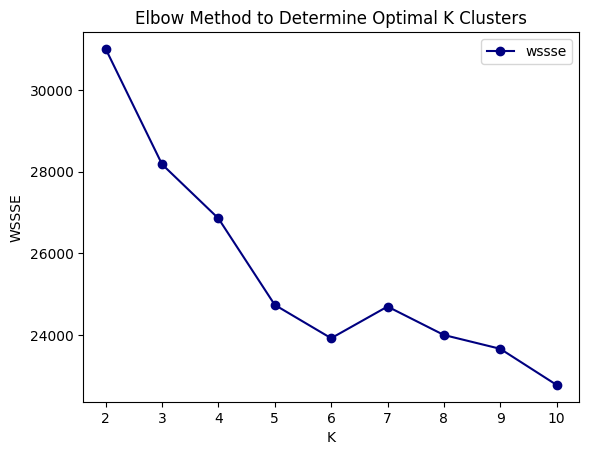

In [33]:
#Converting cost df to pandas and graphing the K and wssse values to make an elbow graph
cost_pd = cost_df.toPandas()
ax = cost_pd.plot(x = 'k',
             y = 'wssse',
             kind = 'line',
             marker = 'o',
             color = 'navy',
             title = 'Elbow Method to Determine Optimal K Clusters')

ax.set_xlabel('K')
ax.set_ylabel('WSSSE')

In [34]:
#Creates a Kmeans clustering with 3 groups
kmeans_3 = KMeans(featuresCol = 'features', k = 3, seed = 1)
model_3 = kmeans_3.fit(customer_data_preproccessed)

#Creates a Kmeans clustering with 4 groups
kmeans_4 = KMeans(featuresCol = 'features', k = 4, seed = 1)
model_4 = kmeans_4.fit(customer_data_preproccessed)

#Creates a Kmeans clustering with 5 groups
kmeans_5 = KMeans(featuresCol = 'features', k = 5, seed = 1)
model_5 = kmeans_5.fit(customer_data_preproccessed)

#Creates a Kmeans clustering with 6 groups
kmeans_6 = KMeans(featuresCol = 'features', k = 6, seed = 1)
model_6 = kmeans_6.fit(customer_data_preproccessed)

#Creates a Kmeans clustering with 7 groups
kmeans_7 = KMeans(featuresCol = 'features', k = 7, seed = 1)
model_7 = kmeans_7.fit(customer_data_preproccessed)

#Makes predictions on which group each customer belongs to based on the two different models
predictions_3 = model_3.transform(customer_data_preproccessed)
predictions_4 = model_4.transform(customer_data_preproccessed)
predictions_5 = model_5.transform(customer_data_preproccessed)
predictions_6 = model_6.transform(customer_data_preproccessed)
predictions_7 = model_7.transform(customer_data_preproccessed)

In [35]:
#Defines evaluator to specify to calculate silhoutte scores
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

#Applies evaliators to each model
silhouette_3 = evaluator.evaluate(predictions_3)
silhouette_4 = evaluator.evaluate(predictions_4)
silhouette_5 = evaluator.evaluate(predictions_5)
silhouette_6 = evaluator.evaluate(predictions_6)
silhouette_7 = evaluator.evaluate(predictions_7)

#Prints silhoutte scores
print(f"Silhouette score for k=3: {silhouette_3}")
print(f"Silhouette score for k=4: {silhouette_4}")
print(f"Silhouette score for k=5: {silhouette_5}")
print(f"Silhouette score for k=6: {silhouette_6}")
print(f"Silhouette score for k=7: {silhouette_7}")

#Based on the output of the silhoutte scores I believe K = 5 is the more optimal model

Silhouette score for k=3: 0.3135884735606854
Silhouette score for k=4: 0.29967449185150685
Silhouette score for k=5: 0.3210767087603839
Silhouette score for k=6: 0.16424027693439877
Silhouette score for k=7: 0.12108222289073374


## Clustering Visualization

Based on the elbow method and silhouette scores, I initially selected **K = 5** as the optimal number of clusters. However, upon visualizing the cluster assignments using PCA, the resulting groupings lacked clear separation and interpretability. I subsequently reevaluated and selected **K = 3**, which had the second-highest silhouette score and produced more coherent and visually distinct clusters. Below, we present the PCA visualizations for both **K = 3** and **K = 5** to illustrate this comparison.


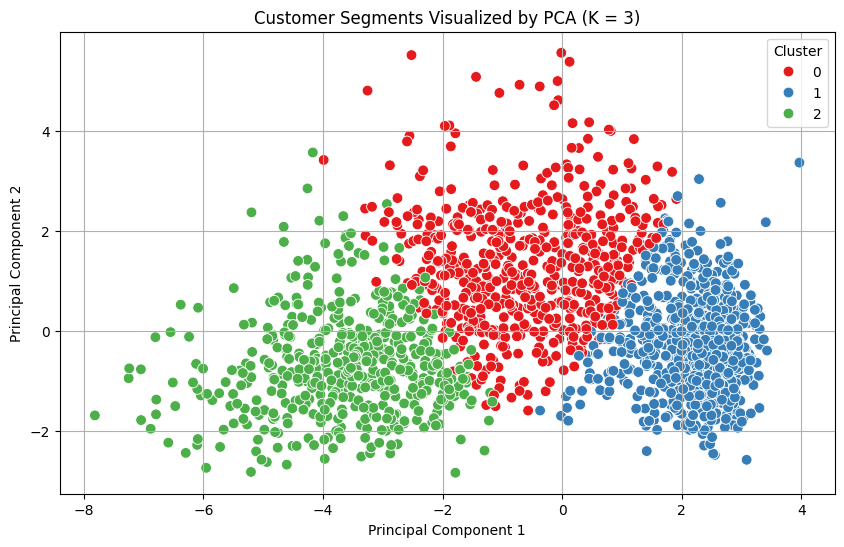

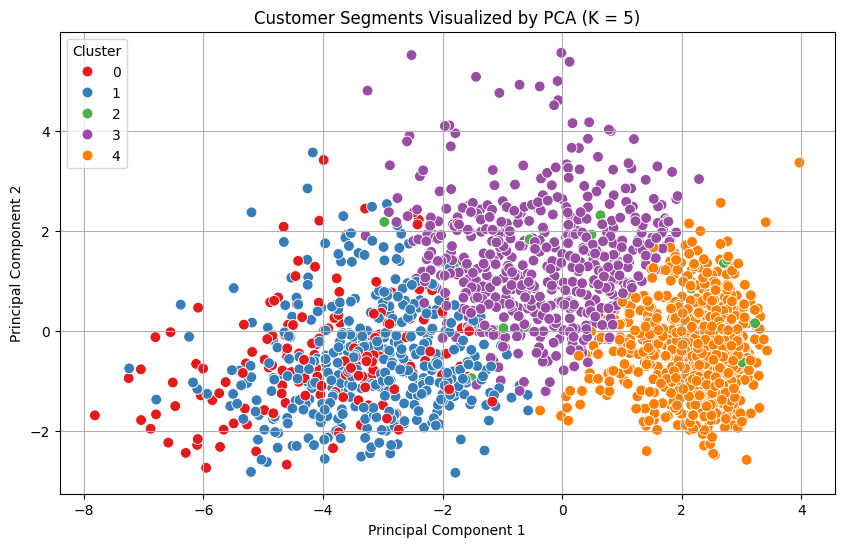

In [36]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#Specifying 2 pca components, fitting and training the PCA model
pca = PCA(k = 2, inputCol = 'features', outputCol = 'pca_features')
pca_model = pca.fit(predictions_3)
pca_result = pca_model.transform(predictions_3)

#Select only the PCA features and cluster prediction
pca_df = pca_result.select("pca_features", "prediction")

#Convert each pca component to its own column for graphing, convering to pandas
pca_pd = pca_df.rdd.map(lambda row: (
    float(row["pca_features"][0]),
    float(row["pca_features"][1]),
    row["prediction"]
)).toDF(["pca1", "pca2", "prediction"]).toPandas()

# Create a new figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot using seaborn on the given axes
sns.scatterplot(data=pca_pd, x="pca1", y="pca2", hue="prediction", palette="Set1", s=60, ax=ax)

# Customize
ax.set_title("Customer Segments Visualized by PCA (K = 3)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(title="Cluster")
ax.grid(True)

#Specifying 2 pca components, fitting and training the PCA model
pca2 = PCA(k = 2, inputCol = 'features', outputCol = 'pca_features')
pca_model2 = pca.fit(predictions_5)
pca_result2 = pca_model.transform(predictions_5)

#Select only the PCA features and cluster prediction
pca_df2 = pca_result2.select("pca_features", "prediction")

#Convert each pca component to its own column for graphing, convering to pandas
pca_pd2 = pca_df2.rdd.map(lambda row: (
    float(row["pca_features"][0]),
    float(row["pca_features"][1]),
    row["prediction"]
)).toDF(["pca1", "pca2", "prediction"]).toPandas()

# Create a new figure and axes object
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Plot using seaborn on the given axes
sns.scatterplot(data=pca_pd2, x="pca1", y="pca2", hue="prediction", palette="Set1", s=60, ax=ax1)

# Customize
ax1.set_title("Customer Segments Visualized by PCA (K = 5)")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.legend(title="Cluster")
ax1.grid(True)

## Determining Cluster Profiles

Following the clustering process, I developed characteristic profiles for each group to better understand the underlying patterns driving the segmentation. This analysis enabled us to extract meaningful, actionable insights from the data.

In [37]:
from pyspark.sql.functions import avg, round as rnd

#Getting average of different variables to build a persona for each group
cluster_profile = predictions_3.groupBy("prediction").agg(
    rnd(avg("income"), 2).alias("avg_income"),
    rnd(avg("age"), 2).alias("avg_age"),
    rnd(avg("total_num_kids"), 2).alias("avg_num_kids"),
    rnd(avg("Recency"), 2).alias("avg_recency"),
    rnd(avg("MntWines"), 2).alias("avg_wine_spend"),
    rnd(avg("MntFruits"), 2).alias("avg_fruit_spend"),
    rnd(avg("MntMeatProducts"), 2).alias("avg_meat_spend"),
    rnd(avg("MntFishProducts"), 2).alias("avg_fish_spend"),
    rnd(avg("MntSweetProducts"), 2).alias("avg_sweet_spend"),
    rnd(avg("MntGoldProds"), 2).alias("avg_gold_spend"),
    rnd(avg("total_spent"), 2).alias("avg_total_spend"),
    rnd(avg("NumWebPurchases"), 2).alias("avg_web_purchases"),
    rnd(avg("NumStorePurchases"), 2).alias("avg_store_purchases"),
    rnd(avg("NumDealsPurchases"), 2).alias("avg_deal_use"),
    rnd(avg("total_campaigns_accepted"), 2).alias("avg_campaign_accepts")
)

#Pivots the education values to get numbers per category to add to cluster profiles
education_pivot = predictions_3.groupBy("prediction").pivot("Education").count().na.fill(0)

#Pivots the maritial status values to get number per category to add to cluster profiles
marital_pivot = predictions_3.groupBy("prediction").pivot("Marital_Status").count().na.fill(0)

#First joins the education pivot table to the cluster profiles, then the maritial status pivot table
profile_with_edu = cluster_profile.join(education_pivot, on="prediction", how="left")
full_cluster_profile = profile_with_edu.join(marital_pivot, on="prediction", how="left")

full_cluster_profile.orderBy('prediction').show(truncate = False)

+----------+----------+-------+------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+------------+--------------------+--------+---------+-----------+------+---+--------+-------+------+--------+-----+
|prediction|avg_income|avg_age|avg_num_kids|avg_recency|avg_wine_spend|avg_fruit_spend|avg_meat_spend|avg_fish_spend|avg_sweet_spend|avg_gold_spend|avg_total_spend|avg_web_purchases|avg_store_purchases|avg_deal_use|avg_campaign_accepts|2n Cycle|Bachelors|High School|Master|PhD|Divorced|Married|Single|Together|Widow|
+----------+----------+-------+------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+------------+--------------------+--------+---------+-----------+------+---+--------+-------+------+--------+-----+
|0         |57993.3   |48.83  |1.13        |48

## Recommendation Algorithms

After creating our clusters, we knew we wanted to make some sort of recommendation algorithm to recommend specific items, and deals to each customer to provide the store with insight on customers that would allow for effetive targeted marketing and inventory managment. We first attempted to model our recommendation system off the one we did in class, but it didn't make much sense for what we where trying to achieve. After brainstorming, discussing, and bouncing ideas off ChatGPT we decided to create three different recommendation algorithms to achieve our goal:

1. Association Rules Mining (FPGrowth)- Based on a project we did in another class we where inspired to use Association Rules Mining to discover relationshipts between product selection, which would allow the store to identify what groups where likely to buy which products and why. After researching online we found that this was able to be achieved through the FPGrowth model in the pyspark.ml.fpm module. This gives the store insight on items they should keep in higher stock if they're often bought in addition to other items.

2. Hybrid recommendation algorithm- This recommendation system determined the favorite (most purchased) items in each group, then for each customer their individual spending history was subtracted from their group favorites, if there was an item that was in their groups favorites that they hadn't bought it would recommend that item to the customer. And in the event that the customer had already bought all their groups favorite items, we advised that the store should recommend trying new varieties of their groups favorites. This will allow the store to make specifically target emails, advertisements, and ad campaigns to each customer.

3. Deal recommendation algorithm- For this algorithm, we where unable to come up with a computational approach to this since deals are words and it would be difficult or impossible to create a model to reach our intended goal. So based on the group characteristics derived above, and research on what grocery stores have offered in the past, we where able to come up with a hard coded algorithm that recommends a specific deal to each group based on their demographics and spending habits.

### Association Rules Mining via FPGrowth

In [38]:
from pyspark.sql.functions import array, lit, when, col, expr, array_contains
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import explode, size
from functools import reduce
from pyspark.sql import DataFrame

# Build a raw items array
customer_basket_raw = customer_data_preproccessed.withColumn(
    "raw_items", array(
        when(col("MntWines") > 0, lit("Wines")),
        when(col("MntFruits") > 0, lit("Fruits")),
        when(col("MntMeatProducts") > 0, lit("Meat")),
        when(col("MntFishProducts") > 0, lit("Fish")),
        when(col("MntSweetProducts") > 0, lit("Sweets")),
        when(col("MntGoldProds") > 0, lit("Gold"))
    )
)

#Filters out nulls from the array
customer_basket = customer_basket_raw.withColumn(
    "items",
    expr("filter(raw_items, x -> x IS NOT NULL)")
).drop("raw_items")

#Defines and fits an FPGrowth (Assocation rules) model
fp_growth = FPGrowth(itemsCol="items", minSupport=0.005, minConfidence=0.6)
fp_model = fp_growth.fit(customer_basket)

product_cols = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]


# Add items column with nulls filtered out
customer_clustered = predictions_3.withColumn(
    "raw_items", array(
        when(col("MntWines") > 0, lit("Wines")),
        when(col("MntFruits") > 0, lit("Fruits")),
        when(col("MntMeatProducts") > 0, lit("Meat")),
        when(col("MntFishProducts") > 0, lit("Fish")),
        when(col("MntSweetProducts") > 0, lit("Sweets")),
        when(col("MntGoldProds") > 0, lit("Gold"))
    )
).withColumn("items", expr("filter(raw_items, x -> x IS NOT NULL)")).drop("raw_items")


# Create a lookup of customer and clusters
cluster_lookup = customer_clustered.select("ID", "items", "prediction")

# Explode item arrays for joining if needed
# Get association rules from model
rules_df = fp_model.associationRules
rules_df.show(truncate=False)

def get_top_rules_per_cluster_fp(customer_clustered_df, top_k_rules=3, min_support=0.005, min_confidence=0.3):

    #Gets the cluster ID's
    cluster_ids = [row['prediction'] for row in customer_clustered_df.select("prediction").distinct().collect()]
    top_rules_by_cluster = []

    for cluster_id in cluster_ids:
        # Filter data to one cluster and drop prediction to avoid FP-Growth conflict
        cluster_df = customer_clustered_df.filter(col("prediction") == cluster_id).drop("prediction")

        # Fit FP-Growth only on this cluster
        fp = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_confidence)
        model = fp.fit(cluster_df)

        # Get top rules
        rules = model.associationRules.orderBy(
                    #col("lift").desc(),
                    #col("support").desc(),
                    col("confidence").desc()
                ).limit(top_k_rules)
        rules = rules.withColumn("cluster", lit(cluster_id))

        #Adds result to list
        top_rules_by_cluster.append(rules)

    if top_rules_by_cluster:
        final_rules_df = reduce(DataFrame.unionByName, top_rules_by_cluster)
        return final_rules_df.select("cluster", "antecedent", "consequent", "support", "confidence", "lift")
    else:
        return None

top_rules_df = get_top_rules_per_cluster_fp(customer_clustered, top_k_rules=5)

top_rules_df.show(truncate=False)

+---------------------+----------+------------------+------------------+------------------+
|antecedent           |consequent|confidence        |lift              |support           |
+---------------------+----------+------------------+------------------+------------------+
|[Fish]               |[Meat]    |0.9994544462629569|0.9999064835520852|0.8282097649186256|
|[Fish]               |[Wines]   |0.9929078014184397|0.9987776519952654|0.8227848101265823|
|[Fish]               |[Gold]    |0.9787234042553191|1.0064789261798075|0.8110307414104883|
|[Fish]               |[Fruits]  |0.8881614839061648|1.0812400673640268|0.7359855334538878|
|[Fish]               |[Sweets]  |0.8854337152209493|1.0880996544826333|0.7337251356238698|
|[Sweets, Gold, Wines]|[Meat]    |1.0               |1.0004522840343735|0.7929475587703436|
|[Sweets, Gold, Wines]|[Fish]    |0.9013683010262258|1.0877395973104262|0.7147377938517179|
|[Sweets, Gold, Wines]|[Fruits]  |0.8962371721778791|1.0910713400426355|0.710669

### Hybrid Recommendation Algorithm Baed on Cluster Preferences and Individual Purchasing History

In [39]:
from pyspark.sql.functions import explode, count, row_number, col, array_except, size, lit, array, collect_list
from pyspark.sql.window import Window

def recommend_for_all_customers(customer_clustered_df, top_n=5):

    #Explode items to get product popularity per cluster
    exploded = customer_clustered_df.withColumn("product", explode("items"))

    #Get top N products per cluster
    product_counts = exploded.groupBy("prediction", "product").agg(count("*").alias("purchase_count"))

    #Creates window specification to perform calculations on group
    windowSpec = Window.partitionBy("prediction").orderBy(col("purchase_count").desc())

    #Ranks product recomendations
    ranked = product_counts.withColumn("rank", row_number().over(windowSpec))
    top_cluster_products = ranked.filter(col("rank") <= top_n)

    #Aggregate top products per cluster into array
    cluster_top_products = top_cluster_products.groupBy("prediction") \
        .agg(collect_list("product").alias("cluster_top_products"))

    #Join with original customer data
    customers_with_cluster_top = customer_clustered_df.join(cluster_top_products, on="prediction", how="left")

    #Calculate recommendations
    with_recommendations = customers_with_cluster_top.withColumn(
        "recommendations",
        array_except("cluster_top_products", "items")
    )

    #Add fallback logic
    from pyspark.sql.functions import when

    #If the customer has already bought all products recomended to their group, reminds them of the products they like that they have already bought
    final_df = with_recommendations.withColumn(
        "fallback_recommendations",
        when(size(col("recommendations")) == 0, col("cluster_top_products")).otherwise(array())
    ).withColumn(
        "reason",
        when(size(col("recommendations")) == 0, lit("Reminder: These are favorites in your segment"))
        .when(size(col("recommendations")) < top_n, lit("Popular in your segment you haven't tried yet"))
        .otherwise(lit("Top products in your segment you haven't bought yet"))
    )

    return final_df.select("ID", "prediction", "items", "recommendations", "fallback_recommendations", "reason")


In [40]:
all_recommendations_df = recommend_for_all_customers(customer_clustered, top_n=5)
all_recommendations_df.show(truncate=False)

+----+----------+-----------------------------------------+---------------+---------------------------------+---------------------------------------------+
|ID  |prediction|items                                    |recommendations|fallback_recommendations         |reason                                       |
+----+----------+-----------------------------------------+---------------+---------------------------------+---------------------------------------------+
|5524|2         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Wines, Meat, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|2174|1         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Meat, Wines, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|4141|0         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Wines, Meat, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|6182|1         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]   

### Hard Coded Deal Recommendation Algorithm

In [41]:
#Hardcoded these values by observing the data and some input from ChatGPT
def persona_product_recommender(df):
    return df.withColumn(
        "recommended_products",
        when(col("prediction") == 0, "Wines, Meat, Gold")
        .when(col("prediction") == 1, "Sweet Products, Meat")
        .when(col("prediction") == 2, "Wines, Fish, Gold")
    ).withColumn(
        "deal_offer_type",
        when(col("prediction") == 0, "Online bundle or BOGO deal")
        .when(col("prediction") == 1, "In-store coupons and family packs")
        .when(col("prediction") == 2, "Loyalty rewards & email promos")
    ).withColumn(
        "deal_persona_summary",
        when(col("prediction") == 0, "Balanced mid-spender with deal interest — engage online")
        .when(col("prediction") == 1, "Price-sensitive shopper — in-store incentives work best")
        .when(col("prediction") == 2, "High-income loyalist — reward with exclusivity and quality")
    )

In [42]:
from pyspark.sql.functions import first

personalized_deals_df = persona_product_recommender(predictions_3)

personalized_deals_df = personalized_deals_df.groupBy("prediction").agg(
    first("recommended_products").alias("recommended_products"),
    first("deal_offer_type").alias("deal_offer_type"),
    first("deal_persona_summary").alias("deal_persona_summary")
).orderBy("prediction")

personalized_deals_df.show(truncate=False)

+----------+--------------------+---------------------------------+----------------------------------------------------------+
|prediction|recommended_products|deal_offer_type                  |deal_persona_summary                                      |
+----------+--------------------+---------------------------------+----------------------------------------------------------+
|0         |Wines, Meat, Gold   |Online bundle or BOGO deal       |Balanced mid-spender with deal interest — engage online   |
|1         |Sweet Products, Meat|In-store coupons and family packs|Price-sensitive shopper — in-store incentives work best   |
|2         |Wines, Fish, Gold   |Loyalty rewards & email promos   |High-income loyalist — reward with exclusivity and quality|
+----------+--------------------+---------------------------------+----------------------------------------------------------+



## Summary Of Clusters & Recommendations

This final section provides a summary of the clustering model, visualized using PCA, a summary of each cluster created, along with an overview of the three recommendation algorithms developed as part of the analysis.

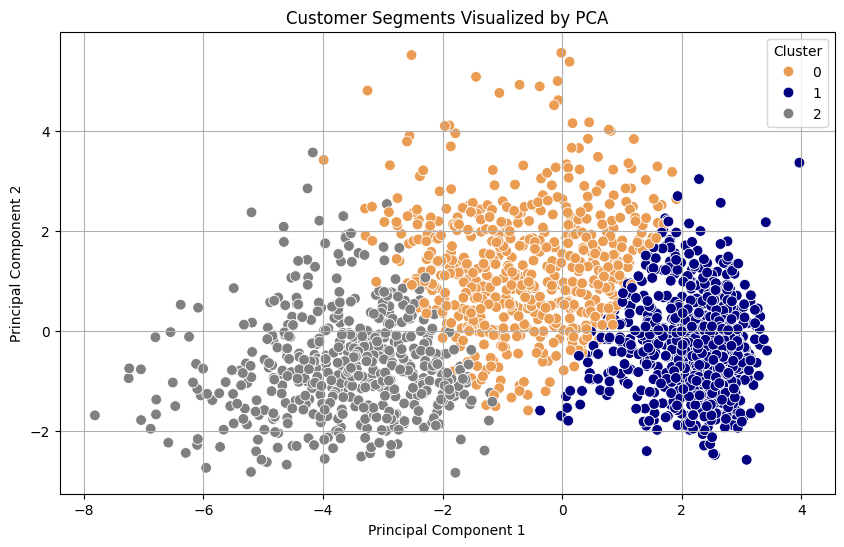

In [43]:
#Creating color pallete for clusters to match the poster
custom_palette = {0: "#ea9c53", 1: "navy", 2: "gray"}

# Create a new figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot using seaborn on the given axes
sns.scatterplot(data=pca_pd, x="pca1", y="pca2", hue="prediction", palette=custom_palette, s=60, ax=ax)

# Customize
ax.set_title("Customer Segments Visualized by PCA")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(title="Cluster")
ax.grid(True)

In [44]:
#Analysis of each group
full_cluster_profile.orderBy('prediction').show(truncate = False)

+----------+----------+-------+------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+------------+--------------------+--------+---------+-----------+------+---+--------+-------+------+--------+-----+
|prediction|avg_income|avg_age|avg_num_kids|avg_recency|avg_wine_spend|avg_fruit_spend|avg_meat_spend|avg_fish_spend|avg_sweet_spend|avg_gold_spend|avg_total_spend|avg_web_purchases|avg_store_purchases|avg_deal_use|avg_campaign_accepts|2n Cycle|Bachelors|High School|Master|PhD|Divorced|Married|Single|Together|Widow|
+----------+----------+-------+------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+------------+--------------------+--------+---------+-----------+------+---+--------+-------+------+--------+-----+
|0         |57993.3   |48.83  |1.13        |48

In [45]:
#Assocation rules
top_rules_df.show(truncate=False)

+-------+---------------------------+----------+------------------+----------+------------------+
|cluster|antecedent                 |consequent|support           |confidence|lift              |
+-------+---------------------------+----------+------------------+----------+------------------+
|1      |[Fruits, Fish, Gold, Wines]|[Meat]    |0.6114832535885167|1.0       |1.0009578544061302|
|1      |[Sweets, Gold, Wines]      |[Meat]    |0.7186602870813397|1.0       |1.0009578544061302|
|1      |[Gold, Wines]              |[Meat]    |0.9502392344497608|1.0       |1.0009578544061302|
|1      |[Fruits, Fish]             |[Meat]    |0.6334928229665072|1.0       |1.0009578544061302|
|1      |[Wines]                    |[Meat]    |0.9875598086124402|1.0       |1.0009578544061302|
|2      |[Sweets, Gold, Wines]      |[Meat]    |0.9193548387096774|1.0       |1.0               |
|2      |[Gold]                     |[Wines]   |0.9695340501792115|1.0       |1.0               |
|2      |[Fish]     

In [46]:
#Recomendations based on cluster preferences and individual history
all_recommendations_df.show(truncate=False)

non_empty_recommendations = all_recommendations_df.filter(size(col("recommendations")) > 0)
non_empty_recommendations.show(truncate=False)

+----+----------+-----------------------------------------+---------------+---------------------------------+---------------------------------------------+
|ID  |prediction|items                                    |recommendations|fallback_recommendations         |reason                                       |
+----+----------+-----------------------------------------+---------------+---------------------------------+---------------------------------------------+
|5524|2         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Wines, Meat, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|2174|1         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Meat, Wines, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|4141|0         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Wines, Meat, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|6182|1         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]   

In [47]:
#Deal recomendations for each group
personalized_deals_df.show(truncate=False)

+----------+--------------------+---------------------------------+----------------------------------------------------------+
|prediction|recommended_products|deal_offer_type                  |deal_persona_summary                                      |
+----------+--------------------+---------------------------------+----------------------------------------------------------+
|0         |Wines, Meat, Gold   |Online bundle or BOGO deal       |Balanced mid-spender with deal interest — engage online   |
|1         |Sweet Products, Meat|In-store coupons and family packs|Price-sensitive shopper — in-store incentives work best   |
|2         |Wines, Fish, Gold   |Loyalty rewards & email promos   |High-income loyalist — reward with exclusivity and quality|
+----------+--------------------+---------------------------------+----------------------------------------------------------+

